In [1]:
%reload_ext autoreload
%autoreload 2

from joblib.parallel import Parallel, delayed

from mne.utils import set_log_level


In [2]:
import copy as cp
import os.path as op
import glob

import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
from paper_single_subject import clean_psd

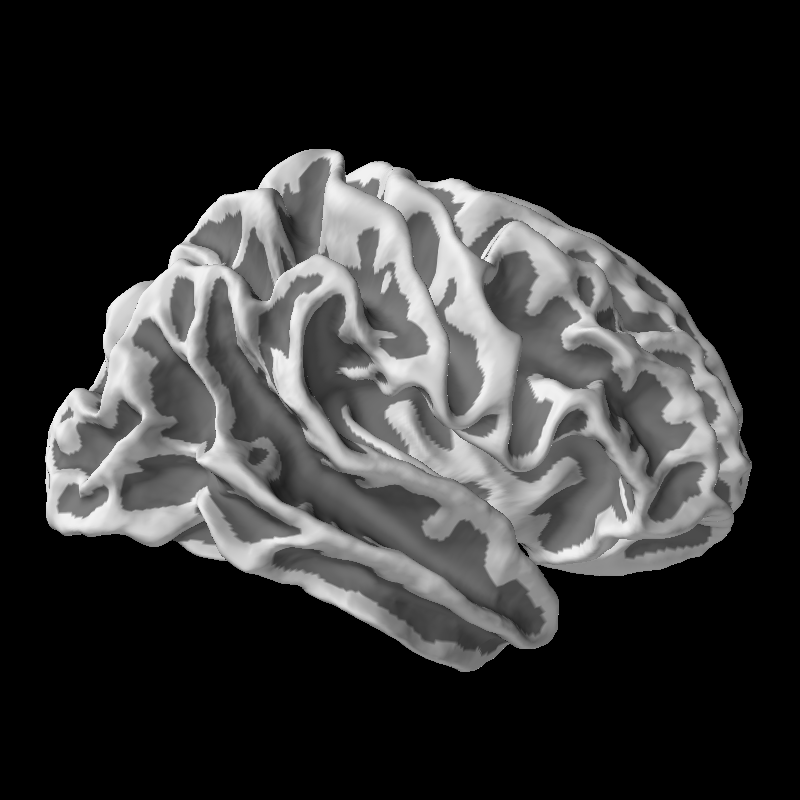

In [4]:
# # def nb_render_brain():
from IPython.display import Image
from mayavi import mlab
mlab.options.offscreen = True
from surfer import Brain
brain = Brain("fsaverage", "rh", "white", subjects_dir='/home/ubuntu/freesurfer/subjects')
brain.save_image('example2.png')
Image('example2.png')

In [6]:
sns.set_style('ticks')
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 


In [7]:
ls /mnt/hcp_subjects/ | wc -l

58


In [8]:
mne.utils.set_log_level('warning')

In [9]:
src_ave = mne.setup_source_space(
    subject='fsaverage', spacing='ico4', fname=None,
    subjects_dir='/mnt/hcp_subjects', add_dist=False)

In [10]:
from hcp_central import colormaps as cmaps

for key, val in cmaps.cmaps.items():
    plt.register_cmap(name=key, cmap=val)

In [11]:
subjects = [ff.split('/')[-1] for ff in glob.glob('/mnt/hcp_subjects/??????')]

In [12]:
ls /mnt/hcp-meg/105923/

105923-head_mri-trans.fif        psd-broad-1-epo.fif
psd-alpha-0-epo.fif              psd-broad-1-spacing-ico4-stc.h5
psd-alpha-0-spacing-ico4-stc.h5  psd-broad-2-epo.fif
psd-alpha-1-epo.fif              psd-broad-2-spacing-ico4-stc.h5
psd-alpha-1-spacing-ico4-stc.h5  rest-run0-preproc-raw.fif
psd-alpha-2-epo.fif              rest-run1-preproc-raw.fif
psd-alpha-2-spacing-ico4-stc.h5  rest-run2-preproc-raw.fif
psd-broad-0-epo.fif              white-ico4-True-subject_on_fsaverage-fwd.fif
psd-broad-0-spacing-ico4-stc.h5  white-ico4-True-subject_on_fsaverage-src.fif


In [13]:
info = mne.read_epochs( op.join('/mnt/hcp-meg', subjects[0], 'psd-broad-0-epo.fif')).info

In [14]:
args = info['description'].split(';')
n_fft = int(args[0].split('=')[-1])
fmax = int(args[1].split('=')[-1])

freqs_broad = np.arange(0, 110, info['sfreq'] / n_fft)
freqs_alpha = np.arange(0, 50, info['sfreq'] / n_fft)

fmin_fit, fmax_fit = freqs_broad[freqs_broad > 0][0], 2  # same sfreq, so global params
subjects_dir = '/mnt/hcp_subjects'


In [15]:
def get_stc_slope(fname, subjects_dir, freqs, src_ave):
    stc = mne.read_source_estimate(fname)
    stc = stc.to_original_src(
        src_orig=src_ave, subjects_dir=subjects_dir)
    psd, this_freqs = clean_psd(stc.data, freqs)
    fmask = (this_freqs >= fmin_fit) & (this_freqs <= fmax_fit)
    lm = LinearRegression(normalize=False).fit(
       np.log10(this_freqs[fmask][:, None]), psd.T[fmask])
    stc._data = lm.coef_
    stc.times = np.array([0])
    stc = stc.morph(subject_to='fsaverage', subjects_dir=subjects_dir, grade=4)
    return stc

In [16]:
%%capture

X_broad, X_alpha = [[], [], []], [[], [], []]
for subject in subjects:
    for run in (0, 1, 2):
        fname = op.join('/mnt/hcp-meg', subject,
                        'psd-broad-{}-spacing-ico4-stc.h5'.format(run))
        stc_broad = get_stc_slope(fname, subjects_dir, freqs_broad, src_ave)
        X_broad[run].append(stc_broad.data)

        fname = op.join('/mnt/hcp-meg', subject,
                        'psd-alpha-{}-spacing-ico4-stc.h5'.format(run))
        stc_alpha = get_stc_slope(fname, subjects_dir, freqs_alpha, src_ave)
        X_alpha[run].append(stc_alpha.data)

X_broad = np.array(X_broad)
X_alpha = np.array(X_alpha)

stc_broad_grand = stc_broad.copy()
stc_broad_grand._data = np.abs(X_broad).mean(0).mean(0)

stc_alpha_grand = stc_alpha.copy()
stc_alpha_grand._data = np.abs(X_alpha).mean(0).mean(0)

In [17]:
"""Functions to make 3D plots with M/EEG data."""
from __future__ import print_function

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Denis Engemann <denis.engemann@gmail.com>
#          Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Eric Larson <larson.eric.d@gmail.com>
#          Mainak Jas <mainak@neuro.hut.fi>
#          Mark Wronkiewicz <wronk.mark@gmail.com>
#
# License: Simplified BSD

import base64
from distutils.version import LooseVersion
from itertools import cycle
import os.path as op
import warnings

import numpy as np
from scipy import linalg

from mne.externals.six import string_types, advance_iterator
from mne.io import _loc_to_coil_trans, Info
from mne.io.pick import pick_types
from mne.io.constants import FIFF
from mne.surface import (get_head_surf, get_meg_helmet_surf, read_surface,
                       transform_surface_to, _project_onto_surface,
                       complete_surface_info)
from mne.transforms import (read_trans, _find_trans, apply_trans,
                          combine_transforms, _get_trans, _ensure_trans,
                          invert_transform, Transform)
from mne.utils import get_subjects_dir, logger, _check_subject, verbose, warn
from mne.viz.utils import mne_analyze_colormap, _prepare_trellis, COLORS, plt_show
from mne.externals.six import BytesIO





def _make_tris_fan(n_vert):
    """Make tris given a number of vertices of a circle-like obj."""
    tris = np.zeros((n_vert - 2, 3), int)
    tris[:, 2] = np.arange(2, n_vert)
    tris[:, 1] = tris[:, 2] - 1
    return tris


def _sensor_shape(coil):
    """Get the sensor shape vertices."""
    rrs = np.empty([0, 2])
    tris = np.empty([0, 3], int)
    id_ = coil['type'] & 0xFFFF
    if id_ in (2, 3012, 3013, 3011):
        # square figure eight
        # wound by right hand rule such that +x side is "up" (+z)
        long_side = coil['size']  # length of long side (meters)
        offset = 0.0025  # offset of the center portion of planar grad coil
        rrs = np.array([
            [offset, -long_side / 2.],
            [long_side / 2., -long_side / 2.],
            [long_side / 2., long_side / 2.],
            [offset, long_side / 2.],
            [-offset, -long_side / 2.],
            [-long_side / 2., -long_side / 2.],
            [-long_side / 2., long_side / 2.],
            [-offset, long_side / 2.]])
        tris = np.concatenate((_make_tris_fan(4),
                               _make_tris_fan(4) + 4), axis=0)
    elif id_ in (2000, 3022, 3023, 3024):
        # square magnetometer (potentially point-type)
        size = 0.001 if id_ == 2000 else (coil['size'] / 2.)
        rrs = np.array([[-1., 1.], [1., 1.], [1., -1.], [-1., -1.]]) * size
        tris = _make_tris_fan(4)
    elif id_ in (4001, 4003, 5002, 7002, 7003):
        # round magnetometer
        n_pts = 15  # number of points for circle
        circle = np.exp(2j * np.pi * np.arange(n_pts) / float(n_pts))
        circle = np.concatenate(([0.], circle))
        circle *= coil['size'] / 2.  # radius of coil
        rrs = np.array([circle.real, circle.imag]).T
        tris = _make_tris_fan(n_pts + 1)
    elif id_ in (4002, 5001, 5003, 5004, 4004, 4005, 6001, 7001):
        # round coil 1st order (off-diagonal) gradiometer
        baseline = coil['base'] if id_ in (5004, 4005) else 0.
        n_pts = 16  # number of points for circle
        # This time, go all the way around circle to close it fully
        circle = np.exp(2j * np.pi * np.arange(-1, n_pts) / float(n_pts - 1))
        circle[0] = 0  # center pt for triangulation
        circle *= coil['size'] / 2.
        rrs = np.array([  # first, second coil
            np.concatenate([circle.real + baseline / 2.,
                            circle.real - baseline / 2.]),
            np.concatenate([circle.imag, -circle.imag])]).T
        tris = np.concatenate([_make_tris_fan(n_pts + 1),
                               _make_tris_fan(n_pts + 1) + n_pts + 1])
    # Go from (x,y) -> (x,y,z)
    rrs = np.pad(rrs, ((0, 0), (0, 1)), mode='constant')
    return rrs, tris


def _limits_to_control_points(clim, stc_data, colormap):
    """Convert limits (values or percentiles) to control points.

    Note: If using 'mne', generate cmap control points for a directly
    mirrored cmap for simplicity (i.e., no normalization is computed to account
    for a 2-tailed mne cmap).

    Parameters
    ----------
    clim : str | dict
        Desired limits use to set cmap control points.

    Returns
    -------
    ctrl_pts : list (length 3)
        Array of floats corresponding to values to use as cmap control points.
    colormap : str
        The colormap.
    """
    # Based on type of limits specified, get cmap control points
    if colormap == 'auto':
        if clim == 'auto':
            colormap = 'mne' if (stc_data < 0).any() else 'hot'
        else:
            if 'lims' in clim:
                colormap = 'hot'
            else:  # 'pos_lims' in clim
                colormap = 'mne'
    if clim == 'auto':
        # Set upper and lower bound based on percent, and get average between
        ctrl_pts = np.percentile(np.abs(stc_data), [96, 97.5, 99.95])
    elif isinstance(clim, dict):
        # Get appropriate key for clim if it's a dict
        limit_key = ['lims', 'pos_lims'][colormap in ('mne', 'mne_analyze')]
        if colormap != 'auto' and limit_key not in clim.keys():
            raise KeyError('"pos_lims" must be used with "mne" colormap')
        clim['kind'] = clim.get('kind', 'percent')
        if clim['kind'] == 'percent':
            ctrl_pts = np.percentile(np.abs(stc_data),
                                     list(np.abs(clim[limit_key])))
        elif clim['kind'] == 'value':
            ctrl_pts = np.array(clim[limit_key])
            if (np.diff(ctrl_pts) < 0).any():
                raise ValueError('value colormap limits must be strictly '
                                 'nondecreasing')
        else:
            raise ValueError('If clim is a dict, clim[kind] must be '
                             ' "value" or "percent"')
    else:
        raise ValueError('"clim" must be "auto" or dict')
    if len(ctrl_pts) != 3:
        raise ValueError('"lims" or "pos_lims" is length %i. It must be length'
                         ' 3' % len(ctrl_pts))
    ctrl_pts = np.array(ctrl_pts, float)
    if len(set(ctrl_pts)) != 3:
        if len(set(ctrl_pts)) == 1:  # three points match
            if ctrl_pts[0] == 0:  # all are zero
                warn('All data were zero')
                ctrl_pts = np.arange(3, dtype=float)
            else:
                ctrl_pts *= [0., 0.5, 1]  # all nonzero pts == max
        else:  # two points match
            # if points one and two are identical, add a tiny bit to the
            # control point two; if points two and three are identical,
            # subtract a tiny bit from point two.
            bump = 1e-5 if ctrl_pts[0] == ctrl_pts[1] else -1e-5
            ctrl_pts[1] = ctrl_pts[0] + bump * (ctrl_pts[2] - ctrl_pts[0])

    return ctrl_pts, colormap


def plot_source_estimates(stc, subject=None, surface='inflated', hemi='lh',
                          colormap='auto', time_label='auto',
                          smoothing_steps=10, transparent=None, alpha=1.0,
                          time_viewer=False, subjects_dir=None, figure=None,
                          views='lat', colorbar=True, clim='auto',
                          cortex="classic", size=800, background="black",
                          foreground="white", initial_time=None,
                          time_unit='s'):
    """Plot SourceEstimates with PySurfer.

    Note: PySurfer currently needs the SUBJECTS_DIR environment variable,
    which will automatically be set by this function. Plotting multiple
    SourceEstimates with different values for subjects_dir will cause
    PySurfer to use the wrong FreeSurfer surfaces when using methods of
    the returned Brain object. It is therefore recommended to set the
    SUBJECTS_DIR environment variable or always use the same value for
    subjects_dir (within the same Python session).

    Parameters
    ----------
    stc : SourceEstimates
        The source estimates to plot.
    subject : str | None
        The subject name corresponding to FreeSurfer environment
        variable SUBJECT. If None stc.subject will be used. If that
        is None, the environment will be used.
    surface : str
        The type of surface (inflated, white etc.).
    hemi : str, 'lh' | 'rh' | 'split' | 'both'
        The hemisphere to display.
    colormap : str | np.ndarray of float, shape(n_colors, 3 | 4)
        Name of colormap to use or a custom look up table. If array, must
        be (n x 3) or (n x 4) array for with RGB or RGBA values between
        0 and 255. If 'auto', either 'hot' or 'mne' will be chosen
        based on whether 'lims' or 'pos_lims' are specified in `clim`.
    time_label : str | callable | None
        Format of the time label (a format string, a function that maps
        floating point time values to strings, or None for no label). The
        default is ``time=%0.2f ms``.
    smoothing_steps : int
        The amount of smoothing
    transparent : bool | None
        If True, use a linear transparency between fmin and fmid.
        None will choose automatically based on colormap type.
    alpha : float
        Alpha value to apply globally to the overlay.
    time_viewer : bool
        Display time viewer GUI.
    subjects_dir : str
        The path to the freesurfer subjects reconstructions.
        It corresponds to Freesurfer environment variable SUBJECTS_DIR.
    figure : instance of mayavi.core.scene.Scene | list | int | None
        If None, a new figure will be created. If multiple views or a
        split view is requested, this must be a list of the appropriate
        length. If int is provided it will be used to identify the Mayavi
        figure by it's id or create a new figure with the given id.
    views : str | list
        View to use. See surfer.Brain().
    colorbar : bool
        If True, display colorbar on scene.
    clim : str | dict
        Colorbar properties specification. If 'auto', set clim automatically
        based on data percentiles. If dict, should contain:

            ``kind`` : str
                Flag to specify type of limits. 'value' or 'percent'.
            ``lims`` : list | np.ndarray | tuple of float, 3 elements
                Note: Only use this if 'colormap' is not 'mne'.
                Left, middle, and right bound for colormap.
            ``pos_lims`` : list | np.ndarray | tuple of float, 3 elements
                Note: Only use this if 'colormap' is 'mne'.
                Left, middle, and right bound for colormap. Positive values
                will be mirrored directly across zero during colormap
                construction to obtain negative control points.

    cortex : str or tuple
        specifies how binarized curvature values are rendered.
        either the name of a preset PySurfer cortex colorscheme (one of
        'classic', 'bone', 'low_contrast', or 'high_contrast'), or the
        name of mayavi colormap, or a tuple with values (colormap, min,
        max, reverse) to fully specify the curvature colors.
    size : float or pair of floats
        The size of the window, in pixels. can be one number to specify
        a square window, or the (width, height) of a rectangular window.
    background : matplotlib color
        Color of the background of the display window.
    foreground : matplotlib color
        Color of the foreground of the display window.
    initial_time : float | None
        The time to display on the plot initially. ``None`` to display the
        first time sample (default).
    time_unit : 's' | 'ms'
        Whether time is represented in seconds ("s", default) or
        milliseconds ("ms").


    Returns
    -------
    brain : Brain
        A instance of surfer.viz.Brain from PySurfer.
    """
    import surfer
    from surfer import Brain, TimeViewer
    import mayavi

    # import here to avoid circular import problem
    from mne.source_estimate import SourceEstimate

    surfer_version = LooseVersion(surfer.__version__)
    v06 = LooseVersion('0.6')
    if surfer_version < v06:
        raise ImportError("This function requires PySurfer 0.6 (you are "
                          "running version %s). You can update PySurfer "
                          "using:\n\n    $ pip install -U pysurfer" %
                          surfer.__version__)

    if time_unit not in ('s', 'ms'):
        raise ValueError("time_unit needs to be 's' or 'ms', got %r" %
                         (time_unit,))

    if initial_time is not None and surfer_version > v06:
        kwargs = {'initial_time': initial_time}
        initial_time = None  # don't set it twice
    else:
        kwargs = {}

    if time_label == 'auto':
        if time_unit == 'ms':
            time_label = 'time=%0.2f ms'
        else:
            def time_label(t):
                return 'time=%0.2f ms' % (t * 1e3)

    if not isinstance(stc, SourceEstimate):
        raise ValueError('stc has to be a surface source estimate')

    if hemi not in ['lh', 'rh', 'split', 'both']:
        raise ValueError('hemi has to be either "lh", "rh", "split", '
                         'or "both"')

    # check `figure` parameter (This will be performed by PySurfer > 0.6)
    if figure is not None:
        if isinstance(figure, int):
            # use figure with specified id
            size_ = size if isinstance(size, (tuple, list)) else (size, size)
            figure = [mayavi.mlab.figure(figure, size=size_)]
        elif not isinstance(figure, (list, tuple)):
            figure = [figure]
        if not all(isinstance(f, mayavi.core.scene.Scene) for f in figure):
            raise TypeError('figure must be a mayavi scene or list of scenes')

    # convert control points to locations in colormap
    ctrl_pts, colormap = _limits_to_control_points(clim, stc.data, colormap)

    # Construct cmap manually if 'mne' and get cmap bounds
    # and triage transparent argument
    if colormap in ('mne', 'mne_analyze'):
        colormap = mne_analyze_colormap(ctrl_pts)
        scale_pts = [-1 * ctrl_pts[-1], 0, ctrl_pts[-1]]
        transparent = False if transparent is None else transparent
    else:
        scale_pts = ctrl_pts
        transparent = True if transparent is None else transparent

    subjects_dir = get_subjects_dir(subjects_dir=subjects_dir,
                                    raise_error=True)
    subject = _check_subject(stc.subject, subject, True)
    if hemi in ['both', 'split']:
        hemis = ['lh', 'rh']
    else:
        hemis = [hemi]

    title = subject if len(hemis) > 1 else '%s - %s' % (subject, hemis[0])
    with warnings.catch_warnings(record=True):  # traits warnings
        brain = Brain(subject, hemi=hemi, surf=surface, curv=True,
                      title=title, cortex=cortex, size=size,
                      background=background, foreground=foreground,
                      figure=figure, subjects_dir=subjects_dir,
                      views=views)

    if time_unit == 's':
        times = stc.times
    else:  # time_unit == 'ms'
        times = 1e3 * stc.times

    for hemi in hemis:
        hemi_idx = 0 if hemi == 'lh' else 1
        if hemi_idx == 0:
            data = stc.data[:len(stc.vertices[0])]
        else:
            data = stc.data[len(stc.vertices[0]):]
        vertices = stc.vertices[hemi_idx]
        if len(data) > 0:
            with warnings.catch_warnings(record=True):  # traits warnings
                brain.add_data(data, colormap=colormap, vertices=vertices,
                               smoothing_steps=smoothing_steps, time=times,
                               time_label=time_label, alpha=alpha, hemi=hemi,
                               colorbar=colorbar, **kwargs)

        # scale colormap and set time (index) to display
#         brain.scale_data_colormap(fmin=scale_pts[0], fmid=scale_pts[1],
#                                   fmax=scale_pts[2], transparent=transparent)

    if initial_time is not None:
        brain.set_time(initial_time)
    if time_viewer:
        TimeViewer(brain)
    return brain



def _3d_to_2d(fig, xyz):
    """Convert 3d points to a 2d perspective using a Mayavi Scene."""
    from mayavi.core.scene import Scene

    if not isinstance(fig, Scene):
        raise TypeError('fig must be an instance of Scene, '
                        'found type %s' % type(fig))
    xyz = np.column_stack([xyz, np.ones(xyz.shape[0])])

    # Transform points into 'unnormalized' view coordinates
    comb_trans_mat = _get_world_to_view_matrix(fig.scene)
    view_coords = np.dot(comb_trans_mat, xyz.T).T

    # Divide through by the fourth element for normalized view coords
    norm_view_coords = view_coords / (view_coords[:, 3].reshape(-1, 1))

    # Transform from normalized view coordinates to display coordinates.
    view_to_disp_mat = _get_view_to_display_matrix(fig.scene)
    xy = np.dot(view_to_disp_mat, norm_view_coords.T).T

    # Pull the first two columns since they're meaningful for 2d plotting
    xy = xy[:, :2]
    return xy


def _get_world_to_view_matrix(scene):
    """Return the 4x4 matrix to transform xyz space to the current view.

    This is a concatenation of the model view and perspective transforms.
    """
    from mayavi.core.ui.mayavi_scene import MayaviScene
    from tvtk.pyface.tvtk_scene import TVTKScene

    if not isinstance(scene, (MayaviScene, TVTKScene)):
        raise TypeError('scene must be an instance of TVTKScene/MayaviScene, '
                        'found type %s' % type(scene))
    cam = scene.camera

    # The VTK method needs the aspect ratio and near and far
    # clipping planes in order to return the proper transform.
    scene_size = tuple(scene.get_size())
    clip_range = cam.clipping_range
    aspect_ratio = float(scene_size[0]) / scene_size[1]

    # Get the vtk matrix object using the aspect ratio we defined
    vtk_comb_trans_mat = cam.get_composite_projection_transform_matrix(
        aspect_ratio, clip_range[0], clip_range[1])
    vtk_comb_trans_mat = vtk_comb_trans_mat.to_array()
    return vtk_comb_trans_mat


def _get_view_to_display_matrix(scene):
    """Return the 4x4 matrix to convert view coordinates to display coordinates.

    It's assumed that the view should take up the entire window and that the
    origin of the window is in the upper left corner.
    """
    from mayavi.core.ui.mayavi_scene import MayaviScene
    from tvtk.pyface.tvtk_scene import TVTKScene

    if not isinstance(scene, (MayaviScene, TVTKScene)):
        raise TypeError('scene must be an instance of TVTKScene/MayaviScene, '
                        'found type %s' % type(scene))

    # normalized view coordinates have the origin in the middle of the space
    # so we need to scale by width and height of the display window and shift
    # by half width and half height. The matrix accomplishes that.
    x, y = tuple(scene.get_size())
    view_to_disp_mat = np.array([[x / 2.0,       0.,   0.,   x / 2.0],
                                 [0.,      -y / 2.0,   0.,   y / 2.0],
                                 [0.,            0.,   1.,        0.],
                                 [0.,            0.,   0.,        1.]])
    return view_to_disp_mat


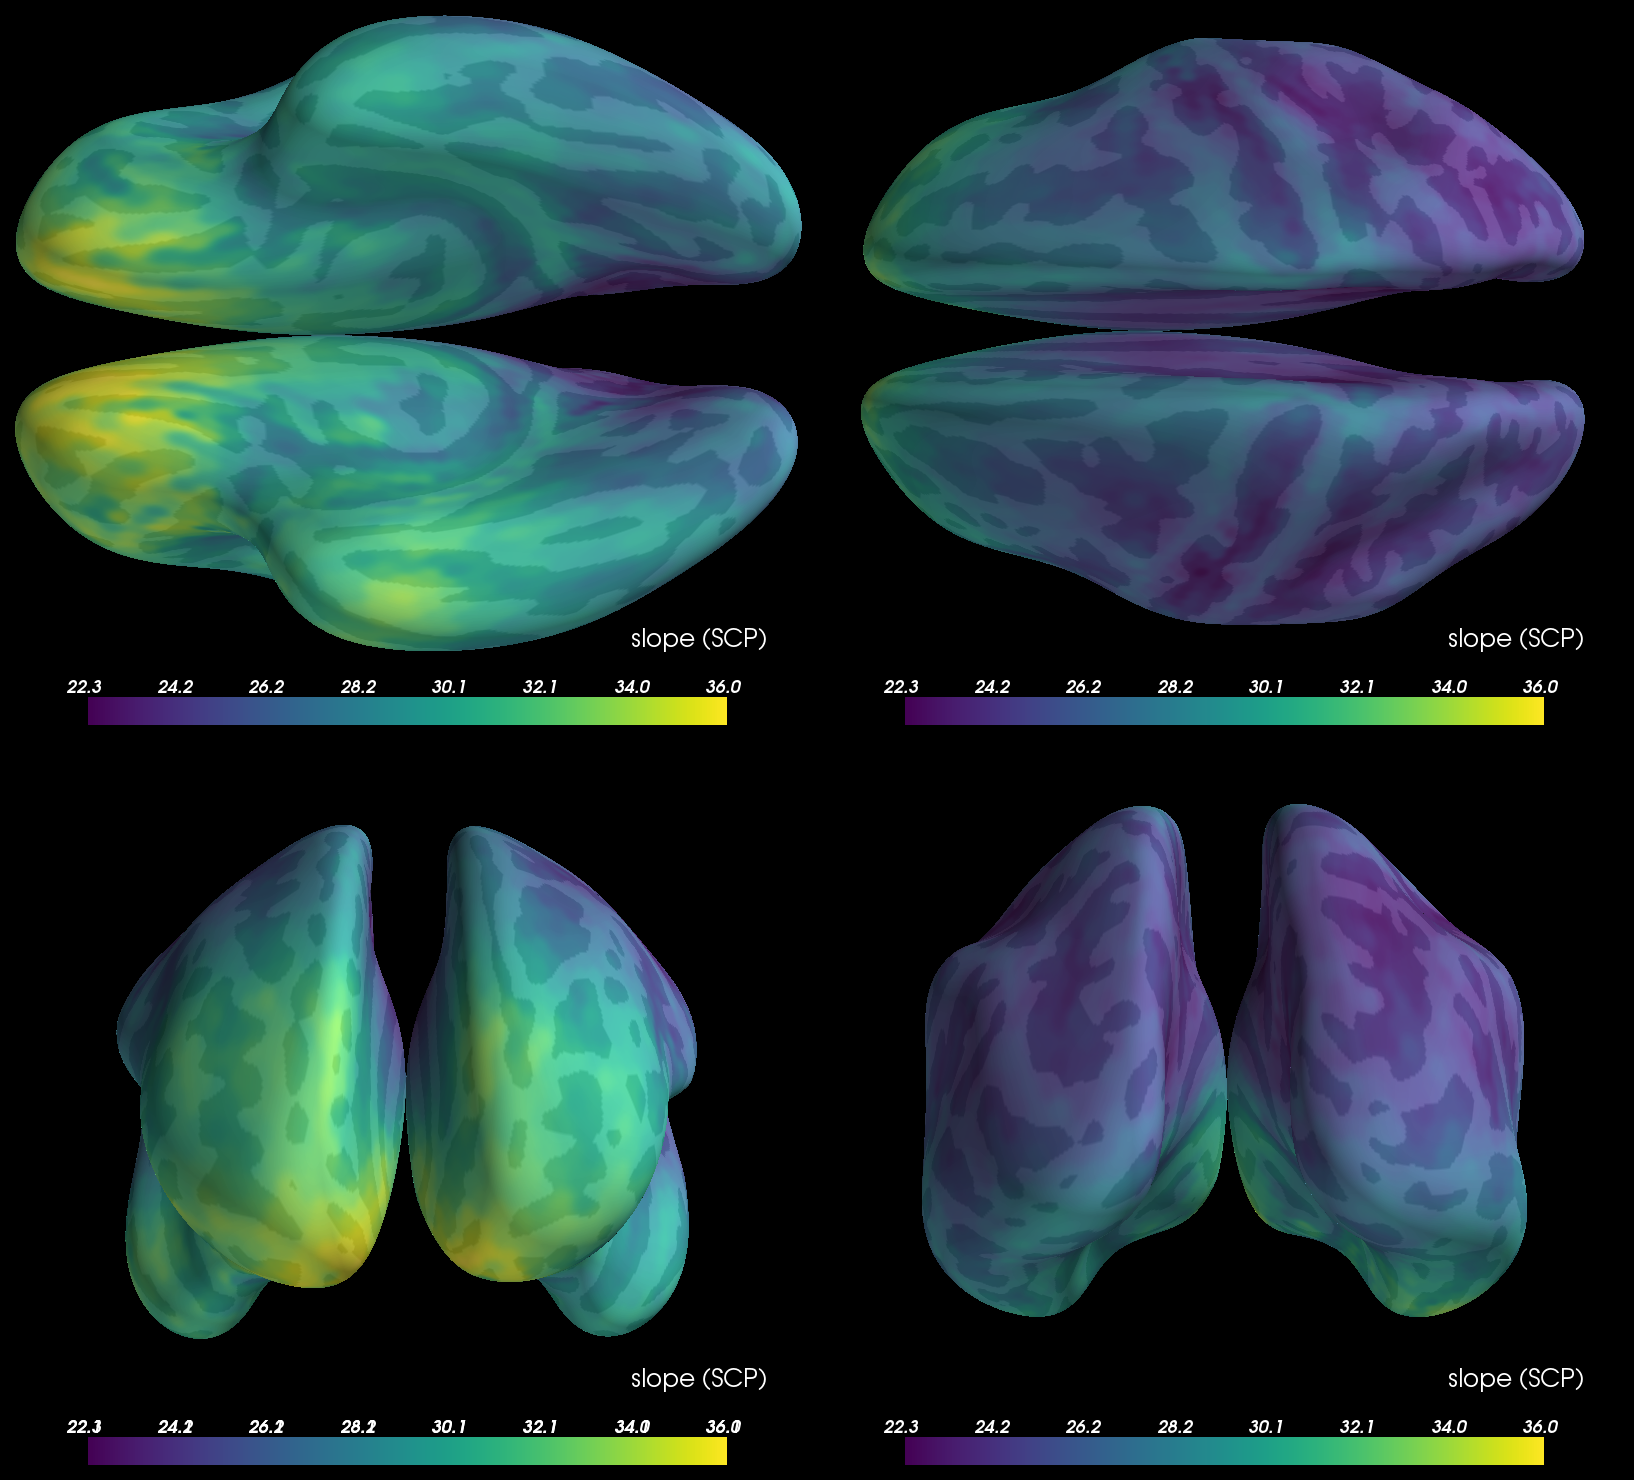

In [18]:
%%capture

brain = plot_source_estimates(stc_broad_grand, subject='fsaverage', subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (SCP)',
                             transparent=False,
#                              clim=dict(kind='percent', lims=[1, 50, 99]),
                             alpha=0.8,
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
# brain.save_image('paper_figures/broad_slope_grand.png')
# Image('paper_figures/broad_slope_grand.png')

brain.save_montage('paper_figures/broad_slope_grand_mont_lh.png', order=['lat', 'med'], col=0)
# Image('paper_figures/broad_slope_grand_mont_rh.png')

brain.save_montage('paper_figures/broad_slope_grand_mont_rh.png', order=['lat', 'med'], col=1)
# Image('paper_figures/broad_slope_grand_mont_rh.png')

brain.save_montage('paper_figures/broad_slope_grand_mont_vd.png', order=[['ven', 'dor'], ['ros', 'cau']], col=1)
Image('paper_figures/broad_slope_grand_mont_vd.png')


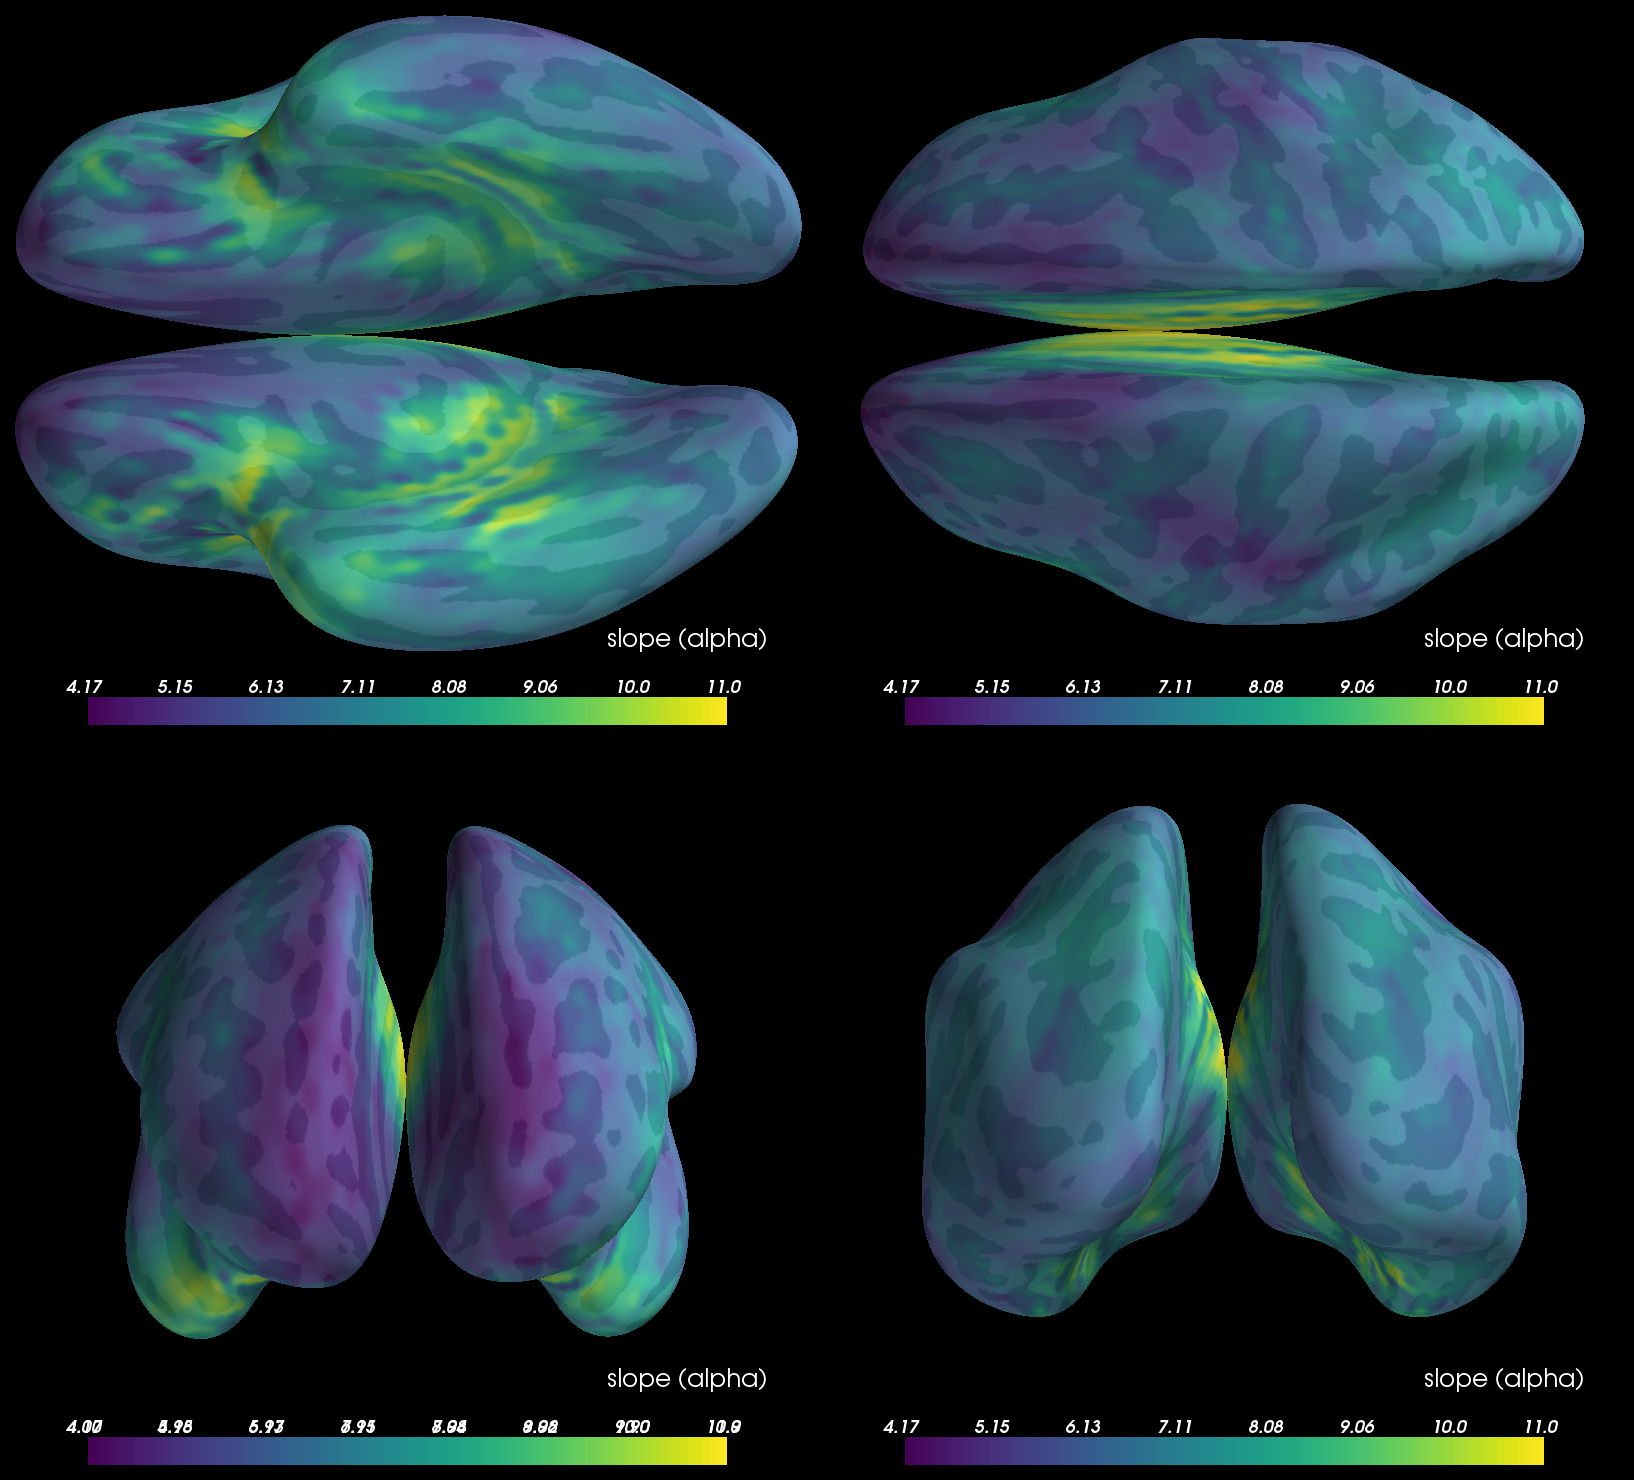

In [22]:
%%capture

brain = plot_source_estimates(stc_alpha_grand, subject='fsaverage', subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (alpha)',
                             transparent=False,
#                              clim=dict(kind='percent', lims=[1, 50, 99])
                             alpha=0.8,
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('paper_figures/alpha_slope_grand.png')
brain.save_montage('paper_figures/alpha_slope_grand_mont_vd.png', order=[['ven', 'dor'], ['ros', 'cau']], col=1)
brain.save_montage('paper_figures/alpha_slope_grand_mont_lh.png', order=['lat', 'med'], col=0)
brain.save_montage('paper_figures/alpha_slope_grand_mont_rh.png', order=['lat', 'med'], col=1)
Image('paper_figures/alpha_slope_grand_mont_vd.png')

In [31]:
def get_stc_power(fname, subjects_dir, freqs, src_ave, franges):
    stc = mne.read_source_estimate(fname)
    stc = stc.to_original_src(
        src_orig=src_ave, subjects_dir=subjects_dir)
    psd, this_freqs = clean_psd(stc.data, freqs)
    stcs = list()
    for fmin, fmax in franges:
        fmask = (this_freqs >= fmin) & (this_freqs <= fmax)
        this_stc = mne.SourceEstimate(np.log10(stc.data[:, fmask]).mean(1)[:, None],
                                      vertices=stc.vertices, tmin=stc.tmin, tstep=stc.tstep,
                                      subject=stc.subject)
        this_stc = this_stc.morph(subject_to='fsaverage', subjects_dir=subjects_dir, grade=4)
        stcs.append(this_stc)
    return stcs

In [32]:
%%capture

X_psd_low, X_psd_alpha = [[], [], []], [[], [], []]
for subject in subjects:
    for run in (0, 1, 2):
        fname = op.join('/mnt/hcp-meg', subject,
                        'psd-broad-{}-spacing-ico4-stc.h5'.format(run))
        stcs = get_stc_power(fname, subjects_dir, freqs_broad, src_ave,
                             franges=[[0, 2], [8, 12]])
        X_psd_low[run].append(stcs[0].data)
        X_psd_alpha[run].append(stcs[1].data)

X_psd_low = np.array(X_psd_low)
X_psd_alpha = np.array(X_psd_alpha)

In [41]:
stc_broad_grand_psd = stcs[0].copy()
stc_broad_grand_psd._data = X_psd_low.mean(0).mean(0)

stc_alpha_grand_psd = stcs[1].copy()
stc_alpha_grand_psd._data = X_psd_alpha.mean(0).mean(0)

In [255]:
# freqs = freqs_broad
# frange = [8, 12]
# stc = mne.read_source_estimate(fname)
# stc = stc.to_original_src(
#     src_orig=src_ave, subjects_dir=subjects_dir)
# psd, this_freqs = clean_psd(stc.data, freqs)
# fmask = (this_freqs >= frange[0]) & (this_freqs <= frange[1])
# stc._data = np.log10(stc.data[:, fmask])
# stc.times = np.array([this_freqs[fmask].mean(0)])


Mapping lh fsaverage -> 133019 (nearest neighbor)...
Mapping rh fsaverage -> 133019 (nearest neighbor)...


In [33]:
from scipy.stats import scoreatpercentile

In [42]:
stc_broad_grand_psd.data

array([[-21.53421404],
       [-21.68144341],
       [-21.74725601],
       ..., 
       [-20.59040949],
       [-21.17435315],
       [-20.95402896]])

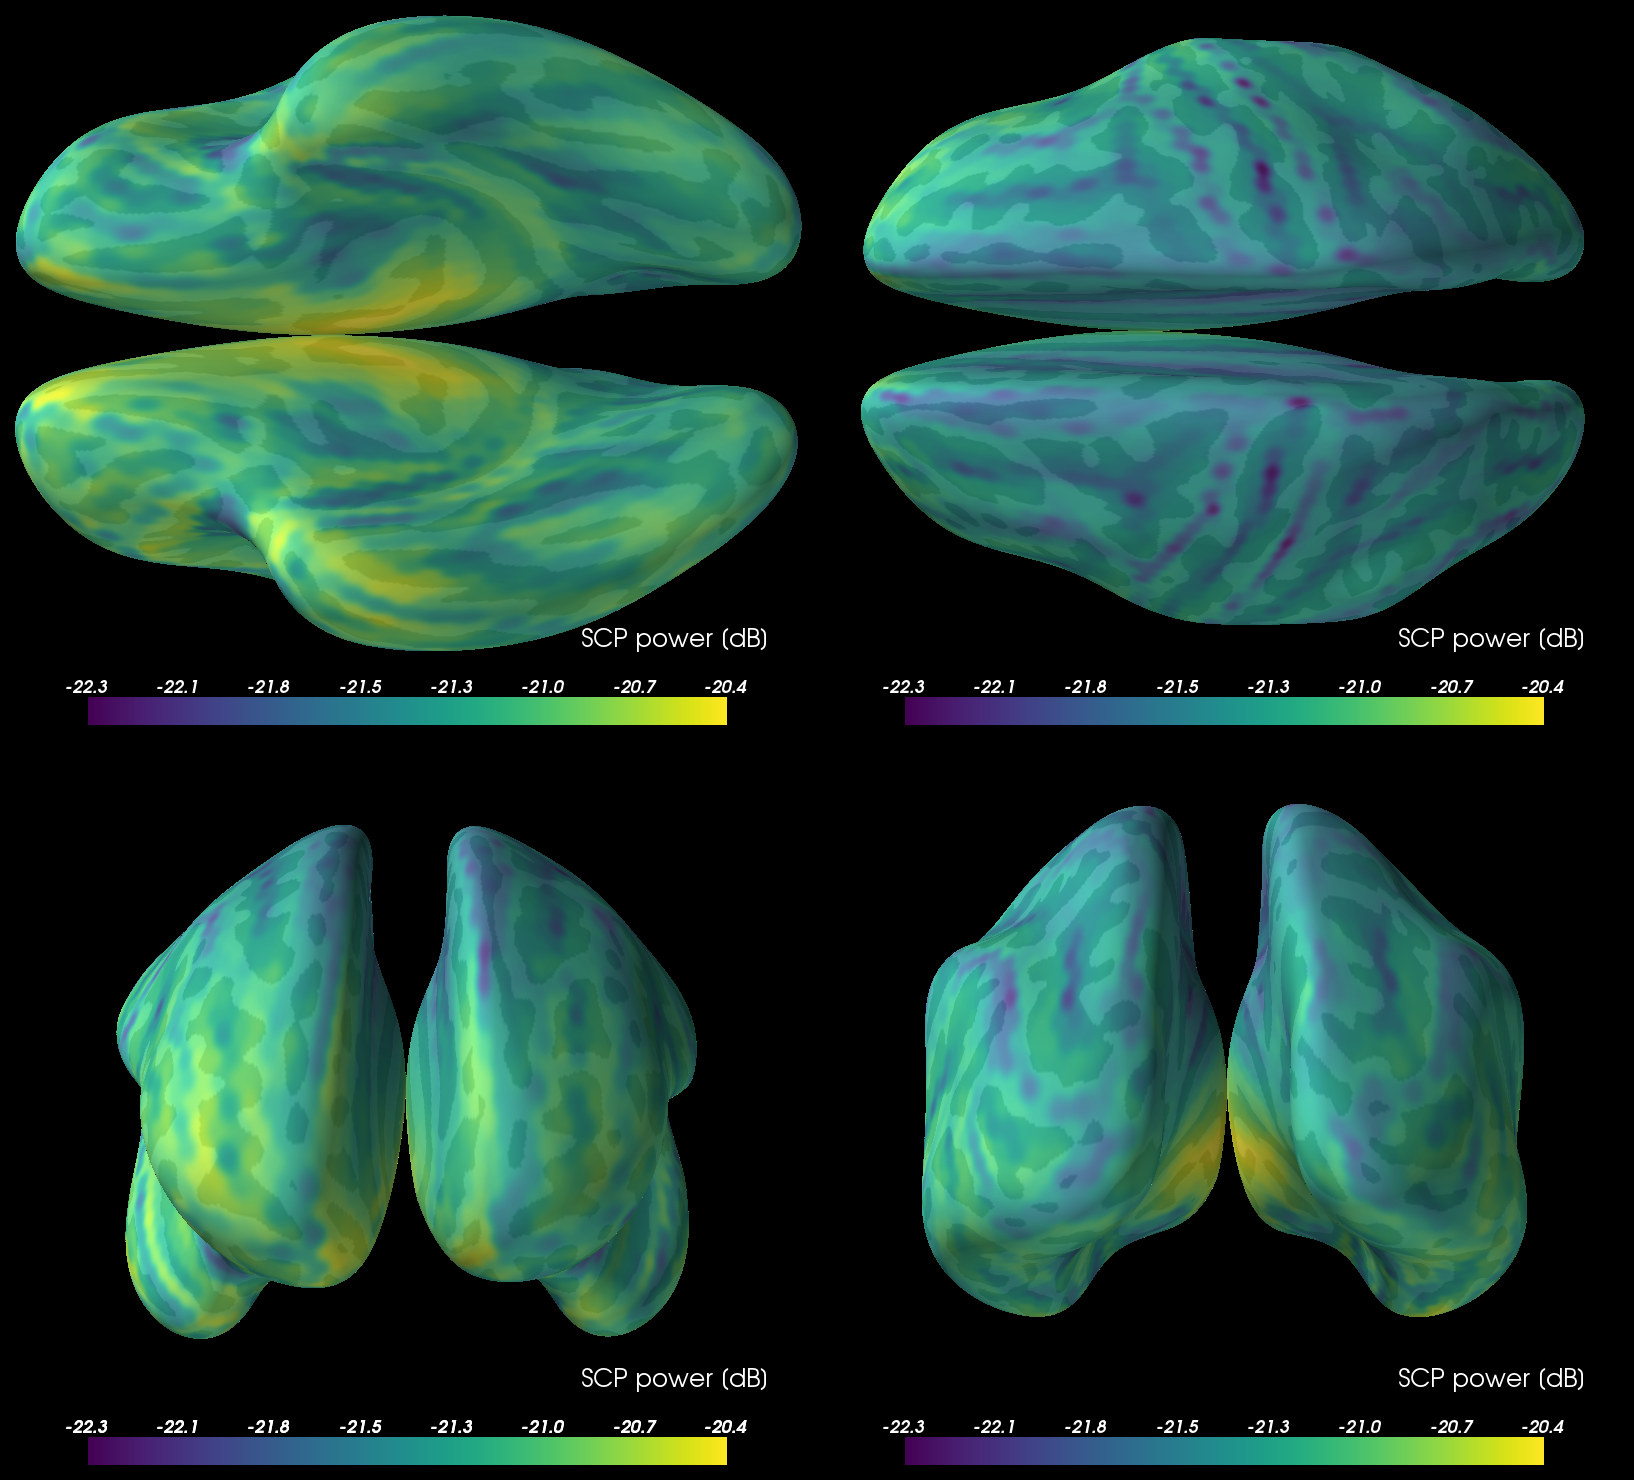

In [43]:
%%capture


lims = [scoreatpercentile(stc_broad_grand.data, pp) for pp in [1, 50, 99]]

brain = plot_source_estimates(stc_broad_grand_psd, subject='fsaverage', subjects_dir=subjects_dir,
                              hemi='both',
                              time_label='SCP power [dB]',
                              transparent=False,
#                              clim=dict(kind='value', lims=lims),
                              colormap=cmaps.viridis.colors, alpha=.8)
brain.show_view('dorsal')
brain.save_image('paper_figures/broad_grand.png')
# Image('paper_figures/broad_grand.png')

brain.save_montage('paper_figures/broad_grand_mont_vd.png', order=[['ven', 'dor'], ['ros', 'cau']], col=1)


brain.save_montage('paper_figures/broad_grand_mont_lh.png', order=['lat', 'med'], col=0)
# Image('paper_figures/broad_slope_grand_mont_rh.png')

brain.save_montage('paper_figures/broad_grand_mont_rh.png', order=['lat', 'med'], col=1)
# Image('paper_figures/broad_slope_grand_mont_rh.png')


Image('paper_figures/broad_grand_mont_vd.png')


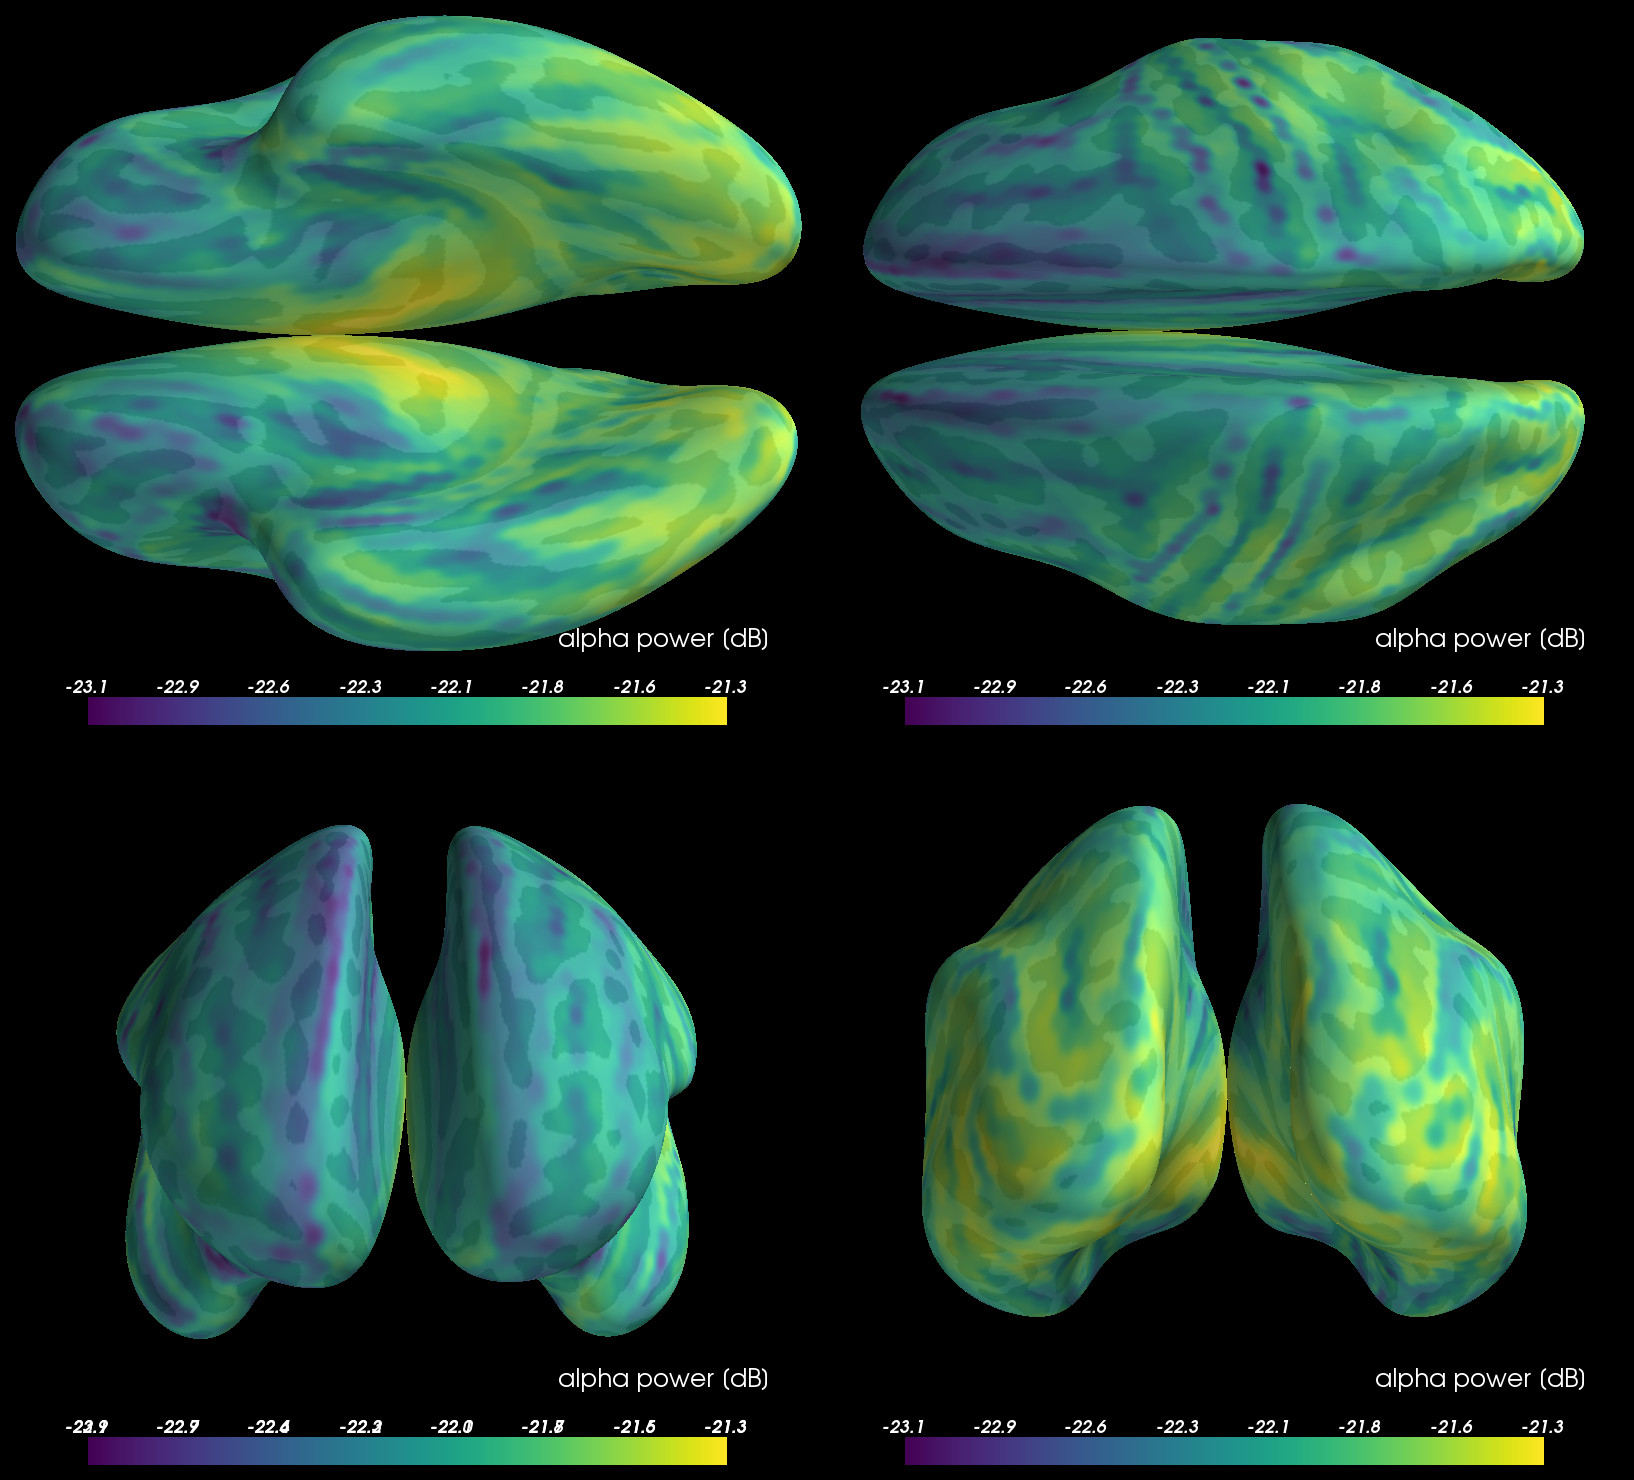

In [44]:
%%capture


lims = [scoreatpercentile(stc_alpha_grand.data, pp) for pp in [1, 50, 99]]

brain = plot_source_estimates(stc_alpha_grand_psd, subject='fsaverage', subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='alpha power [dB]',
                             transparent=False,
#                              clim=dict(kind='value', lims=lims),
                             alpha=0.8,
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('paper_figures/alpha_grand.png')
# Image('paper_figures/broad_grand.png')

brain.save_montage('paper_figures/alpha_grand_mont_vd.png', order=[['ven', 'dor'], ['ros', 'cau']], col=1)


brain.save_montage('paper_figures/alpha_grand__mont_lh.png', order=['lat', 'med'], col=0)
# Image('paper_figures/broad_slope_grand_mont_rh.png')

brain.save_montage('paper_figures/alpha_grand__mont_rh.png', order=['lat', 'med'], col=1)
# Image('paper_figures/broad_slope_grand_mont_rh.png')


Image('paper_figures/alpha_grand_mont_vd.png')


Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=-4.12e-01 fmid=0.00e+00 fmax=4.12e-01 transparent=0
Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=-4.12e-01 fmid=0.00e+00 fmax=4.12e-01 transparent=0


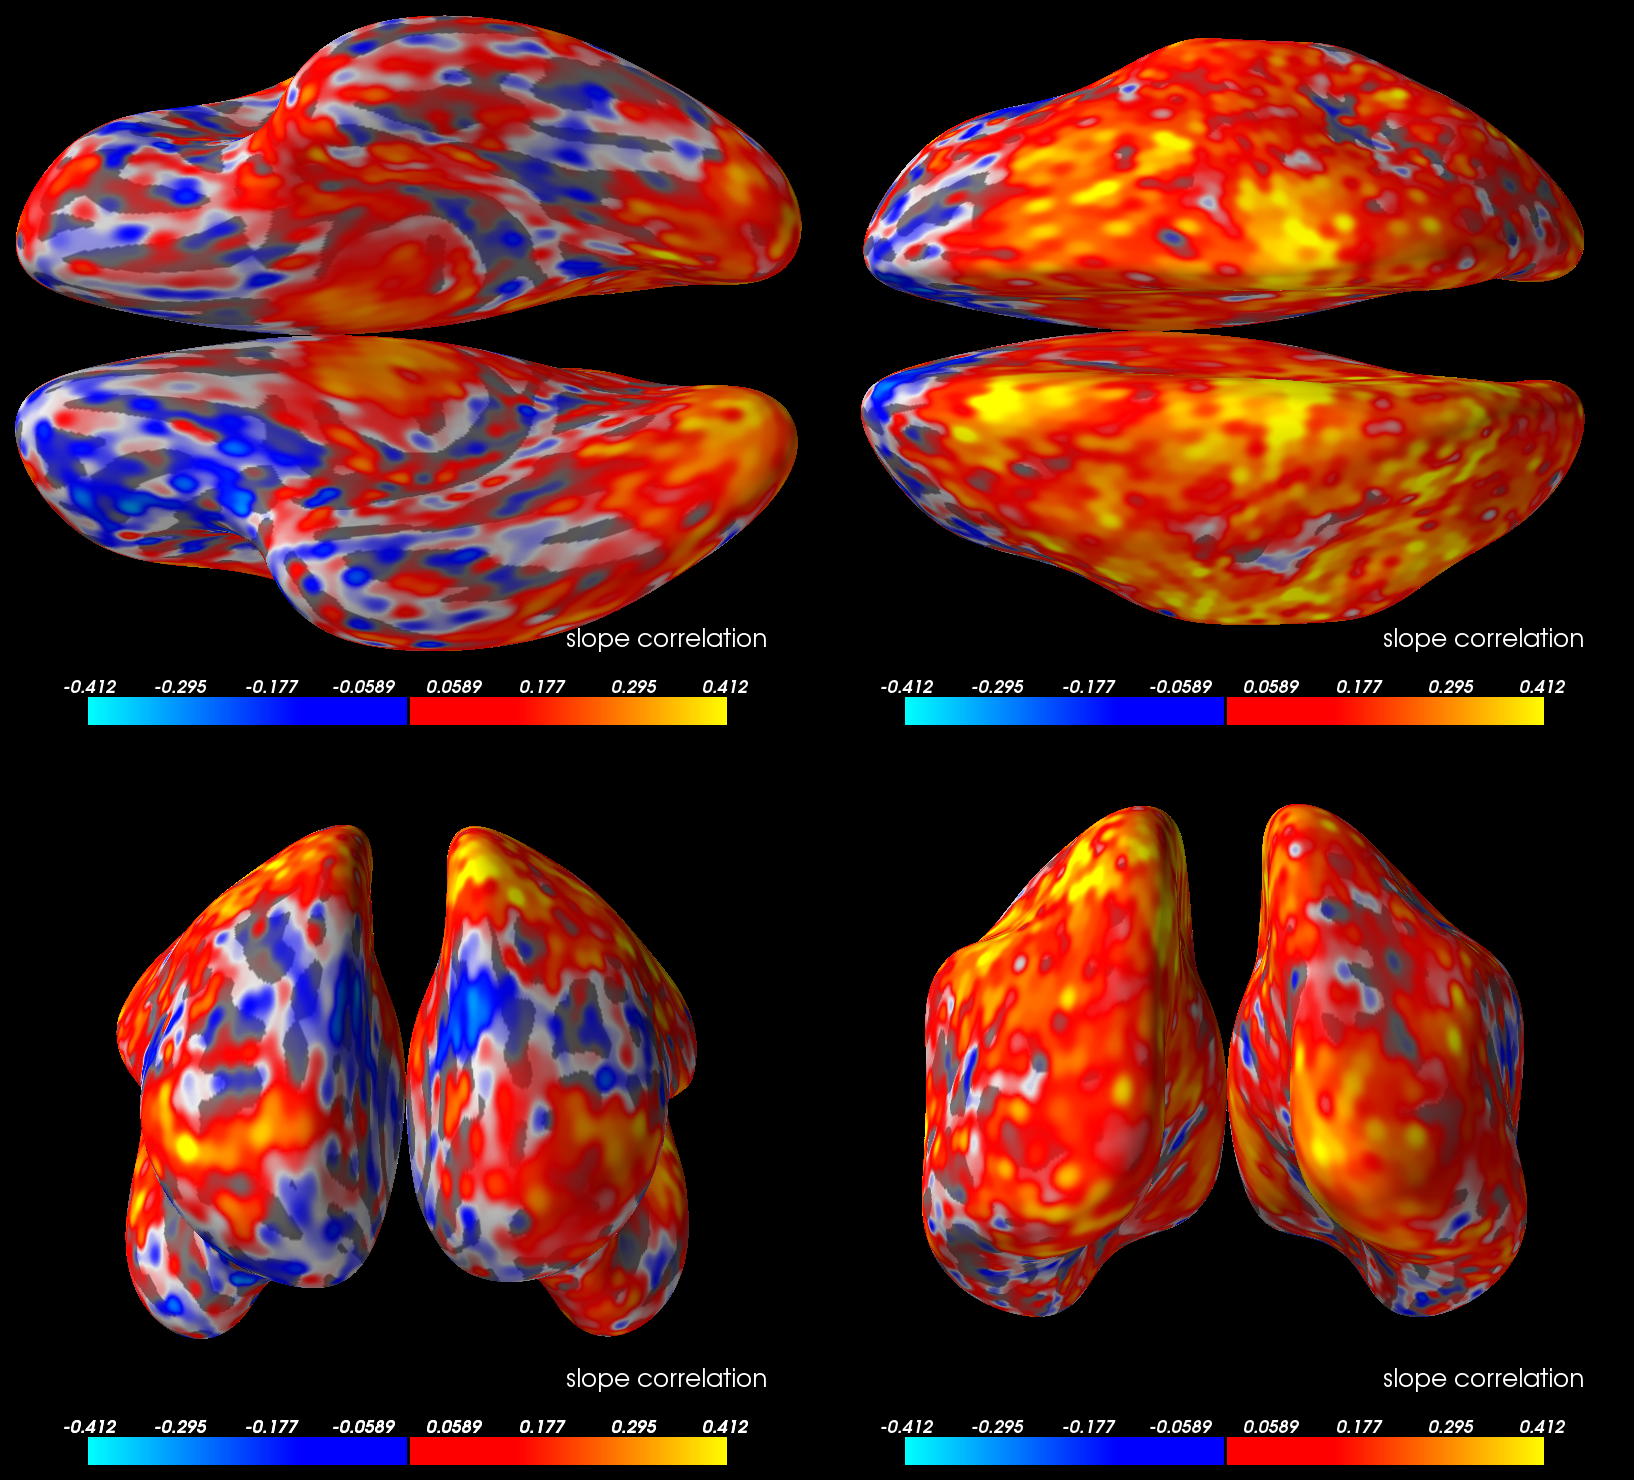

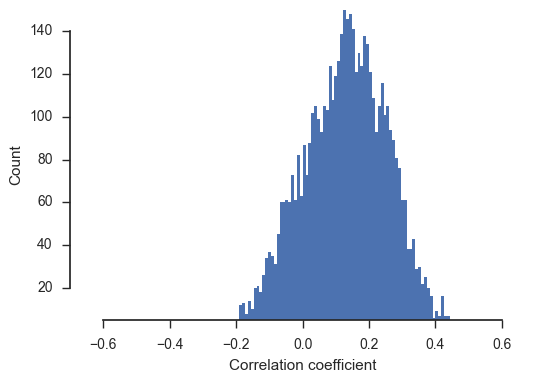

In [23]:
from library.stats import compute_corr
X_corr = compute_corr(np.abs(X_alpha[..., 0].mean(0).T),
                      np.abs(X_broad[..., 0].mean(0).T))

%matplotlib inline
fig = plt.figure()
plt.hist(X_corr, 100, lw=0);
plt.xlim(-0.7, 0.7)
plt.ylim(5, 150)
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
sns.despine(trim=True)
fig.savefig('paper_figures/corr_coef_hist.pdf')

stc_corr = stc_broad.copy()
stc_corr._data[:, 0] = X_corr

view = 'dorsal'
brain = stc_corr.plot(subject='fsaverage', subjects_dir=subjects_dir,
                  hemi='both',
                  time_label='slope correlation',
                  transparent=False,
                  clim=dict(kind='percent', pos_lims=[1, 50, 99]))
# brain.show_view(view)
# brain.save_image('paper_figures/corr_slope_grand_%s.png' % view)
# Image('paper_figures/corr_slope_grand_%s.png' % view)

# brain.save_montage('paper_figures/corr_slope_grand_mont_lh.png', order=['lat', 'med'], col=0)
# Image('paper_figures/corr_slope_grand_mont_lh.png')

# brain.save_montage('paper_figures/corr_slope_grand_mont_rh.png', order=['lat', 'med'], col=1)
# Image('paper_figures/corr_slope_grand_mont_lh.png')

brain.save_montage('paper_figures/corr_slope_grand_mont_vd.png', order=[['ven', 'dor'], ['ros', 'cau']], col=1)


brain.save_montage('paper_figures/corr_slope_grand_mont_lh.png', order=['lat', 'med'], col=0)
# Image('paper_figures/broad_slope_grand_mont_rh.png')

brain.save_montage('paper_figures/corr_slope_grand_mont_rh.png', order=['lat', 'med'], col=1)
# Image('paper_figures/broad_slope_grand_mont_rh.png')


Image('paper_figures/corr_slope_grand_mont_vd.png')

In [54]:
X_psd_alpha[..., 0].std(-1)

(3, 56)

In [60]:
def get_summary(fname, subjects_dir, src_ave, freqs):
    stc = mne.read_source_estimate(fname)
    stc = stc.to_original_src(
        src_orig=src_ave, subjects_dir=subjects_dir)
    psd, this_freqs = clean_psd(stc.data, freqs)
    return {'mean': psd.mean(0), 'std': psd.std(0)}

In [61]:
%%capture

X_summary_std, X_summary_mean = [[], [], []], [[], [], []]
for subject in subjects:
    for run in (0, 1, 2):
        fname = op.join('/mnt/hcp-meg', subject,
                        'psd-broad-{}-spacing-ico4-stc.h5'.format(run))
        stcs = get_summary(fname, subjects_dir, src_ave, freqs_broad)
        X_summary_std[run].append(stcs['std'])
        X_summary_mean[run].append(stcs['mean'])

X_summary_std = np.array(X_summary_std)
X_summary_mean = np.array(X_summary_mean)

In [186]:
fmask_alpha = (freqs_broad >= 8) & ((freqs_broad <= 12))
psd_alpha = X_summary_mean[..., fmask_alpha].mean(-1).T


In [185]:
alpha_sorter

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 2, 1],
       [2, 1, 0],
       [2, 0, 1],
       [1, 0, 2],
       [1, 0, 2],
       [0, 2, 1],
       [0, 2, 1],
       [1, 0, 2],
       [0, 1, 2],
       [1, 2, 0],
       [2, 0, 1],
       [2, 0, 1],
       [1, 2, 0],
       [2, 1, 0],
       [1, 2, 0],
       [1, 2, 0],
       [0, 1, 2],
       [2, 0, 1],
       [2, 0, 1],
       [0, 2, 1],
       [2, 1, 0],
       [1, 0, 2],
       [0, 1, 2],
       [0, 2, 1],
       [0, 2, 1],
       [1, 0, 2],
       [0, 2, 1],
       [2, 1, 0],
       [0, 1, 2],
       [0, 2, 1],
       [1, 0, 2],
       [1, 2, 0],
       [0, 1, 2],
       [1, 2, 0],
       [0, 1, 2],
       [1, 0, 2],
       [1, 0, 2],
       [2, 1, 0],
       [1, 0, 2],
       [2, 0, 1],
       [1, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [2, 0, 1],
       [1, 0, 2],
       [0, 2, 1],
       [1, 0, 2],
       [1, 2, 0],
       [1, 2, 0],
       [0, 2, 1],
       [1, 0, 2],
       [0, 2, 1],
       [0,

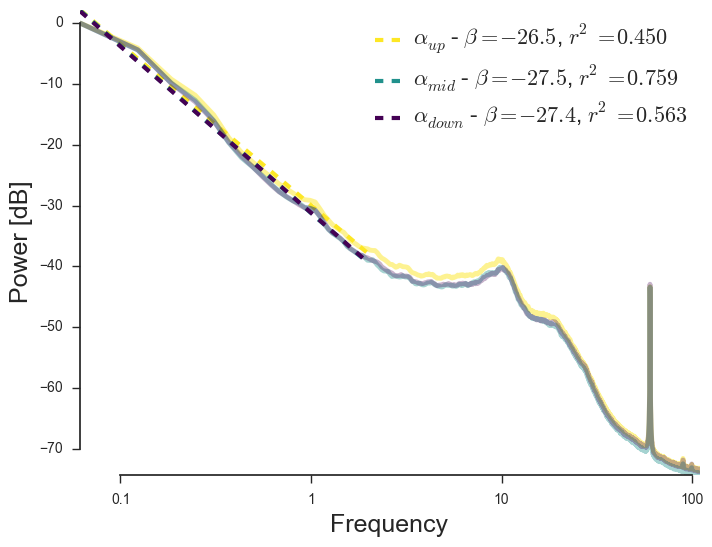

In [195]:
no_sorter = np.array([[0, 1, 2] for _ in range(56)])
alpha_sorter = psd_alpha.argsort()
# sorter = alpha_sorter
sorter = no_sorter

X_up = np.array([X_summary_mean[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 2])])
X_mid = np.array([X_summary_mean[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 1])])
X_down = np.array([X_summary_mean[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 0])])

colors = [cmaps.viridis(ii) for ii in (0, 0.5, 1.)][::-1] 

freqs = freqs_broad[1:]
fmask = (freqs >= 0) & (freqs <= 2)
plt.figure(figsize=(8, 6))

for ii, psd in enumerate((X_up, X_mid, X_down)):

    plt.plot(np.log10(freqs), psd.mean(0), color=colors[ii], linewidth=3.5, alpha=[0.5, 0.4, 0.3][ii])
    
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]), psd.T[fmask])
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
    fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)

    plt.plot(np.log10(freqs[fmask]), fit_line, color=colors[ii], linewidth=3,
            linestyle='--', label=r"$\alpha_{%s}$ - $\beta=%0.1f$, $r^2=%0.3f$" % (
                ['up', 'mid', 'down'][ii], lm.coef_.ravel().mean(0), np.mean(scores)))

    plt.xticks(np.log10([0.1, 1, 10, 100,]), [0.1, 1, 10, 100])
    sns.despine(trim=True)

for tt in plt.legend().get_texts():
    tt.set_size(16)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Power [dB]', fontsize=18)

In [162]:
X_psd = [[], [], []]
for subject in subjects:
    for run in (0, 1, 2):
        epochs = mne.read_epochs(
            op.join('/mnt/hcp-meg', subject, 'psd-broad-%s-epo.fif' % run))
        psd, freqs = clean_psd(epochs.get_data().mean(0), freqs_broad)
        X_psd[run].append(psd)
X_psd = np.array(X_psd)

In [204]:
X_psd.shape

(3, 56, 248, 1771)

In [211]:
fmask_alpha = (freqs_broad >= 8) & ((freqs_broad <= 12))
psd_alpha_sn = X_psd[..., fmask_alpha].mean(-1).T.mean(0)

X_summary_mean_sn = X_psd.mean(2)

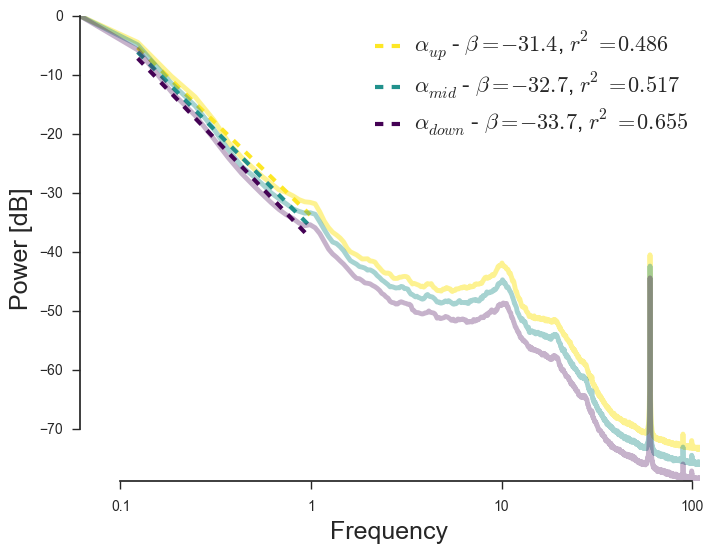

In [217]:
no_sorter = np.array([[0, 1, 2] for _ in range(56)])
alpha_sorter = psd_alpha_sn.argsort()
sorter = alpha_sorter
# sorter = no_sorter
# 
X_up = np.array([X_summary_mean_sn[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 2])])
X_mid = np.array([X_summary_mean_sn[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 1])])
X_down = np.array([X_summary_mean_sn[sort_idx][sub_idx] for sub_idx, sort_idx in enumerate(sorter[:, 0])])

colors = [cmaps.viridis(ii) for ii in (0, 0.5, 1.)][::-1] 

freqs = freqs_broad[1:]
fmask = (freqs >= 0.1) & (freqs <= 1)
plt.figure(figsize=(8, 6))

for ii, psd in enumerate((X_up, X_mid, X_down)):

    plt.plot(np.log10(freqs), psd.mean(0), color=colors[ii], linewidth=3.5, alpha=[0.5, 0.4, 0.3][ii])
    
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]), psd.T[fmask])
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
    fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)

    plt.plot(np.log10(freqs[fmask]), fit_line, color=colors[ii], linewidth=3,
            linestyle='--', label=r"$\alpha_{%s}$ - $\beta=%0.1f$, $r^2=%0.3f$" % (
                ['up', 'mid', 'down'][ii], lm.coef_.ravel().mean(0), np.mean(scores)))

    plt.xticks(np.log10([0.1, 1, 10, 100,]), [0.1, 1, 10, 100])
    sns.despine(trim=True)

for tt in plt.legend().get_texts():
    tt.set_size(16)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Power [dB]', fontsize=18)

In [218]:
from mne.report import Report

In [224]:
X_psd.shape

(3, 56, 248, 1771)

In [239]:
rep = Report(title='up and down states')
colors = [cmaps.viridis(ii) for ii in (0, 0.5, 1.)][::-1] 
fmask = (freqs >= 0.1) & (freqs <= 1)
for ii, this_sorter in enumerate(alpha_sorter):
    subject = subjects[ii]

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    axes = axes.ravel()
    for ax, idx, label in zip(axes, this_sorter[::-1], ['up', 'mid', 'down']):
        
        psd = X_psd[idx][ii]
        psd_mean = psd.mean(0)
        psd_std = psd.std(0)
        
        ax.plot(np.log10(freqs), psd_mean, label=label, color=colors[idx])
        ax.fill_between(np.log10(freqs),
                         psd_mean + psd_std,
                         psd_mean - psd_std, alpha=0.3, color=colors[idx])

        lm = LinearRegression(normalize=False).fit(
           np.log10(freqs[fmask][:, None]), psd.T[fmask])
        scores = [r2_score(x, y) for x, y in zip(
                  lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
        fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
        ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
                linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
                    lm.coef_.ravel().mean(0), np.mean(scores)))

        ax.set_xlim(*np.log10([0.05, 150]))
        ax.set_xticks(np.log10([0.1, 1, 10, 100]))
        ax.set_xticklabels([0.1, 1, 10, 100])
        for tt in ax.legend().get_texts():
            tt.set_fontsize(16)

        ax.set_ylabel('Power [dB]')
        ax.set_xlabel('Frequency [Hz]', fontsize=18)
        ax.set_ylim(-100, 50)
        ax.grid(True)
    sns.despine(trim=True)
    rep.add_figs_to_section(figs=[fig], section='averages', captions=[subject])


In [247]:
rep.save('paper_figures/up_down.html', open_browser=False, overwrite=True)

'/home/ubuntu/github/meg_study_dynamic_scales/scripts/paper_figures/up_down.html'

In [235]:
from IPython.display import HTML


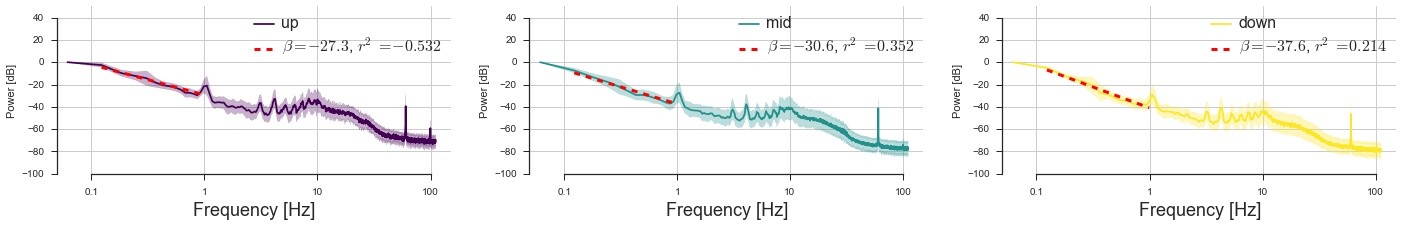

In [236]:
HTML('test.html')